# Project 2: DCT Compression of an Interframe

# Preface
In order to explore the most pedagogical style, the format of the lab instructions have changed. Instead of organizing the functions in the order of the tasks, we will group them depending on their function, and let you finish them in which ever order you so prefer. Furthermore, we will not put the functions together with the instructions for that function. Instead, we will put all instructions at the top of the notebook. Under that the supporting function boxes. At the end we put the main loop, so in case you make many changes at once you can 'run all' without crashing.

# Instructions
The goal of this project is to get familiar with how to perform a DCT video compression through the predictive frame coding technique. 

## Introduction
This is the last lab assignment of the course. You will have to combine a lot of functions to finish it. Some of your old code can be recycled, but some must be tuned. Make sure to read the instructions carefully and make yourself a clear understanding of how the different methods of compression might interfere which each other and how the data will be modified as we transform, compress and reverse transform it.

## Lab Procedures and Tasks
1. Download the given video file in the course files(test_video) and add it to the project files.
2. Copy the following old functions into this document:.

# Tasks
Prework
1. Extract frame number 80 and 85 from the video file
2. Convert the two frames from RGB to YUV by using your function and keep the two Y frames
3. Calculate the Y frame difference
between frame 85 and 80 by “ frame 85- frame 80”
4. Divide the difference frame into 8x8 patches

Encoding
5. Use your DCT function to calculate DCT coefficients for the patches

Lossy compression
6. Quantize the DCT coefficients with a quantization step of appropriate size

Lossless compression
7. Construct a Huffman codebook for the quantized DCT coefficients
8. Implement Huffman encoding of the quantized DCT coefficients

Decoding
9. Implement Huffman decoding of the quantized DCT coefficients
10. Reconstruct the difference patches by DCT decoding

Postwork
11. Reconstruct the Y frame difference by putting the patches together again 
12. Reconstruct Y frame 85 with Y frame 80 and the Y frame difference
13. Compute the quality of reconstructed Y frame 85 by calculating PSNR

# Report
In the report, you should:
1. Print Y frame 85 and its reconstructed version 
2. Print the frame difference between Y frame 80 and 85 
3. Include the probability distribution of Y frame difference, and its entropy 
4. Include PSNR of the reconstructed Y frame 85
5. Attach your entire notebook

Note: The entire report should be one pdf file. Don’t forget to write down your group name and all member names.

Upload your report to “Assignments/Project2”.

Deadline is 26 May 2021 23:59

In [1]:
#LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import pylab

In [8]:
# RGB2YUV
# Put RGB2YUV code here (Lab1)
def frameRGB2YUV(RGBframe):
    # Transform RGB to YUV
    imagearray = np.array(RGBframe)
    imagearray = imagearray.astype("uint8")
    transform_matrix = np.array(
        [[0.2126, 0.7152, 0.0722], [-0.09991, -0.33609, 0.436], [0.615, -0.55861, -0.05639]])
    YUVframe = np.matmul(imagearray, transform_matrix)
    y, u, v = cv2.split(YUVframe)

    # Downsamples/Upsamples
    dim_down = (int(u.shape[1] / 2), int(u.shape[0] / 2))
    dim_up = (int(u.shape[1]), int(u.shape[0]))

    u_comp = cv2.resize(cv2.resize(u, dim_down), dim_up)
    v_comp = cv2.resize(cv2.resize(v, dim_down), dim_up)

    YUVframe = cv2.merge((y, u_comp, v_comp))
    YUVframe = np.clip(YUVframe, 0, 255)
    YUVframe = YUVframe.astype("uint8")

    return YUVframe


# PSNR
# Put your CalculatePSNR code here (Lab1)
def CalculatePSNR(im1, im2):
    PSNR = 10 * np.log10(255**2/(np.mean(im1)-np.mean(im2))**2)
    return PSNR


# ENTROPY
def Calcent(input):
    Y = input
    pix_num = cap_w * cap_h  # amount of pixels in frame
    P = []  # list for all probabilities
    p = {}  # dict for Huffman
    # Calculate probabilities
    for i in np.unique(Y).astype(int):
        Pi = np.sum(Y == i) / pix_num
        P.append(Pi)
        p[str(i)] = Pi

    # Plot histogram
    for number in p.keys():
        plt.bar(int(number), p[number], color="steelblue")
    plt.title("Probability Distribution")
    plt.show()

    # Calculate entropy
    P_arr = np.array(P)  # convert to numpy array
    S = np.sum(-P_arr * np.log2(P_arr))
    return S, p


# HUFFMAN ENCODING
def Huffmanenco(OriginalImage, Huffdict):
    encoded_lst = []
    for row in OriginalImage:
        for number in row:
            encoded_lst.append(Huffdict[str(int(number))])
    encoded_array = np.array(encoded_lst)
    return encoded_array


# HUFFMAN DECODING
def Huffmandeco(EncodedImage, Huffdict):
    rev_Huffdict = {}
    for key, value in Huffdict.items():
        rev_Huffdict[value] = key
    decoded_image = np.zeros(len(EncodedImage))
    for i in range(len(EncodedImage)):
        decoded_image[i] = rev_Huffdict[EncodedImage[i]]
    decoded_image = decoded_image.reshape((cap_h, cap_w))
    return decoded_image

# IMAGE DIFFERENCE


def Diffimage(frame1, frame2):
    diff = frame2 - frame1
    return diff


# RECONSTRUCT
def Reconsimage(frame, framedifference):
    reconst = frame + framedifference
    return reconst


# CUT
# Put your Cutimage code here which cuts into 8x8 pixel patches organized in a 'pile' (Proj1)
def Cutimage(frame):
    return np.reshape(frame, (3600, 8, 8))


# PASTE
# Put your pasteimage code here which creates a frame from patches (Proj1)
def Pasteimage(pileofpatches):
    return np.reshape(pileofpatches, (360, 640))
    print('your code here')


# HUFFMAN DICTIONARY
def Huffmandict(p):

    # This function generates a binary Huffman code dictionary
    # Input should be a dictionary where the keys are the pixel intensities that
    # are found in your frame and the value of each key is the probability of
    # that intensity to appear (i.e. FrequencyOfIntensity/TotalNumberOfPixels)
    # Consider this example: input = {'255':0.0312, '254':0.0000829, et cetera}
    # Output will be a dictionary where the keys are the pixel intensities
    # found in your input dictionary, and the values are the binary codes for
    # the keys.
    '''Return a Huffman code for an ensemble with distribution p.'''
    normalizationFactor = sum(p.values())
    for k in p.keys():
        p[k] = p[k] / normalizationFactor
    EPSILON = 0.0001
    assert(sum(p.values()) < 1.0 + EPSILON)  # Ensure probabilities sum to 1
    assert(sum(p.values()) > 1.0 - EPSILON)  # Ensure probabilities sum to 1
    # Base case of only two symbols, assign 0 or 1 arbitrarily
    if len(p) == 2:
        return dict(zip(p.keys(), "01"))
    # Create a new distribution by merging lowest prob. pair
    p_prime = p.copy()
    a1, a2 = lowest_prob_pair(p)
    p1, p2 = p_prime.pop(a1), p_prime.pop(a2)
    p_prime[str(a1) + '|' + str(a2)] = p1 + p2
    # Recurse and construct code on new distribution
    c = Huffmandict(p_prime)
    ca1a2 = c.pop(str(a1) + '|' + str(a2))
    c[str(a1)], c[str(a2)] = ca1a2 + '0', ca1a2 + '1'
    return c


def lowest_prob_pair(p):
    '''Return pair of symbols from distribution p with lowest probabilities.'''
    assert(len(p) >= 2)  # Ensure there are at least 2 symbols in the dist.

    sorted_p = sorted(p.items(), key=lambda x: x[1])

    return sorted_p[0][0], sorted_p[1][0]


In [3]:
#DCT
def DCTconv_quant(patch):
  normalized = patch/255
  normfloat = np.float32(normalized)
  DCTpatch = cv2.dct(normfloat)*255
  
  #quantization matrix Q
  Q = np.array([[16, 11, 10, 16 ,24, 40, 51 ,61], 
       [12 ,12, 14, 19, 26, 58 ,60 ,55], 
       [14, 13, 16, 24, 40, 57, 69 ,56], 
       [14, 17, 22, 29, 51, 87, 80, 62], 
       [18, 22, 37 ,56 ,68, 109 ,103 ,77], 
       [24, 35, 55, 64, 81, 104 ,113, 92], 
       [49, 64, 78, 87, 103, 121, 120, 101], 
       [72, 92, 95, 98, 112, 100, 103 ,99]])
  
  f = 1

  quantized_patch = np.trunc(DCTpatch/(Q*f))
  quantized_patch = quantized_patch*(Q*f)


  return quantized_patch

  
  # Performs DCT conversion on a frame and quantize it
  # Input a patch
  # Output a converted patch with quantization

In [4]:
#iDCT (without quantization)

def iDCTconv(patch):
  # Input should be de-normalized before iDCT, think about what may occur if you put normalized values.
  patch = cv2.idct(patch)

  return patch.astype(int)

  
  # Performs JUST inverse DCT (no quantization this time)
  # Input a converted patch
  # Output a patch

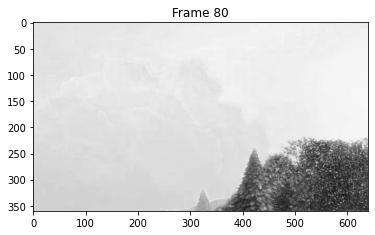

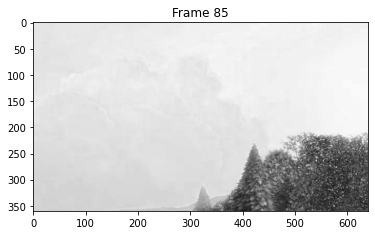

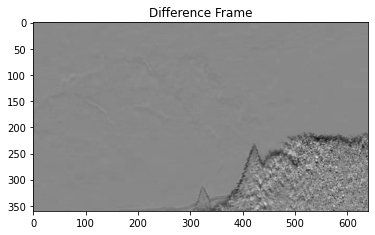

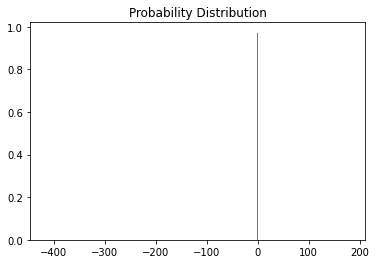

Entropy:  0.34862406907460275


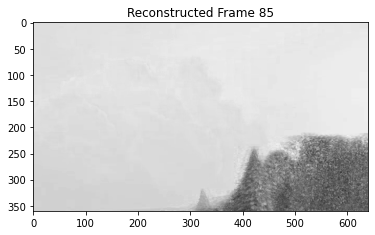

PSNR:  59.60549337189943 dB


In [9]:
#Run your functions here according to the instuctions
#VIDEO

cap = cv2.VideoCapture('test_video.mp4')

if cap.isOpened() == False:
    print("That's probably not the name of your clip")

# Some information about the video file
cap_e = int(cap.get(0)) # Elapsed video time in milliseconds
cap_w = int(cap.get(3)) # Frame width
cap_h = int(cap.get(4)) # Frame height
cap_r = int(cap.get(5)) # Frame rate
cap_l = int(cap.get(7)) # Length in number of frames
# Under VideoCapture::get is a list of attributes
# https://docs.opencv.org/2.4/modules/highgui/doc/reading_and_writing_images_and_video.html#videocapture-open

# Set up to write video. You can set title and resolution.
result = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'MP4V'), cap_r, (cap_w, cap_h))

#prepping to extract a random frame
count = 0

while True:
    # ret is true if video.read() returns a frame
    # frame is the frame returned
    ret, frame = cap.read()

    if ret is True:
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      
      #extracts a random frame
      if count == 79:
        #cv2.imwrite("lab1video.jpg", frame)
        YUVframe80 = np.rint(frameRGB2YUV(frame))
        frame80 = YUVframe80[:,:,0].astype(int)
        plt.imshow(frame80, cmap = "gray")
        plt.title("Frame 80")
        plt.show()
      if count == 84:
        #cv2.imwrite("lab1video2.jpg", frame)
        YUVframe85 = np.rint(frameRGB2YUV(frame))
        frame85 = YUVframe85[:,:,0].astype(int)
        plt.imshow(frame85, cmap = "gray")
        plt.title("Frame 85")
        plt.show()
      count += 1

        # 'q' to cancel
      if cv2.waitKey(1) & 0xFF == ord('q'):
          break
    else:
        break

# Close down
cap.release()
result.release()
cv2.destroyAllWindows()



#PREWORK
difference_frame = Diffimage(frame80,frame85)
plt.imshow(difference_frame, cmap = "gray")
plt.title("Difference Frame")
plt.show()

patches = Cutimage(difference_frame)

conv_patches = []
for patch in patches:
  #preform DCT conversion and quantization
  conv_patches.append(DCTconv_quant(patch))

conv_patches = np.array(conv_patches)

#reassemble the DCT converted patches
converted_frame = Pasteimage(conv_patches)

#calculate entropy and create a probability dict
entropy, prob_dict = Calcent(converted_frame) #HÄR KAN DET FINNAS FEL SEN

print("Entropy: ", entropy)
#create a huffman dictionary from the probabilities
huffman_dict = Huffmandict(prob_dict)

#huffman encoding
huff_encoded_frame = Huffmanenco(converted_frame, huffman_dict)

#huffman decoding
huff_decoded_frame = Huffmandeco(huff_encoded_frame,huffman_dict)

patches2 = Cutimage(huff_decoded_frame)

reconstructed_patches = []
for patch in patches2:
  #preform DCT conversion and quantization
  reconstructed_patches.append(iDCTconv(patch))

# reassemble the iDCT converted patches
reconstructed_difference_frame = Pasteimage(reconstructed_patches)
  
#calculate the new frame 85
new_frame85 = Reconsimage(frame80 , reconstructed_difference_frame)

plt.imshow(new_frame85, cmap= "gray")
plt.title("Reconstructed Frame 85")
plt.show()
print("PSNR: ", CalculatePSNR(new_frame85, frame85), "dB")
